# Too high dFF in some sessions
- Check the individual examples
    - ROI quality
    - F, Fneu, and baseline calculation
- Using results from 230719_signal_QC.ipynb

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.ndimage import filters

base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')
mice = [25,27,30,36,39]
planes = range(1,9)

In [105]:
mouse = 36
session = 7
plane = 4

if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2

dff_saved = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session:03d}/plane0/dff.npy')
# These are from all ROIs

In [106]:
iscell = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session:03d}/plane0/iscell.npy')
iscell_inds = np.where(iscell[:,0])[0]
dff_cells = dff_saved[iscell_inds,:]
max_dff_vals = np.amax(dff_cells, axis=1)
min_dff_vals = np.amin(dff_cells, axis=1)
len(np.where(max_dff_vals>15)[0])


8

In [107]:
np.where(min_dff_vals<-10)[0]

array([34, 42, 94], dtype=int64)

In [108]:
np.where(max_dff_vals>50)[0]

array([42, 94], dtype=int64)

In [111]:
iscell_inds[94]

116

Text(0.5, 1.0, 'Mouse 36, session 7, plane 4')

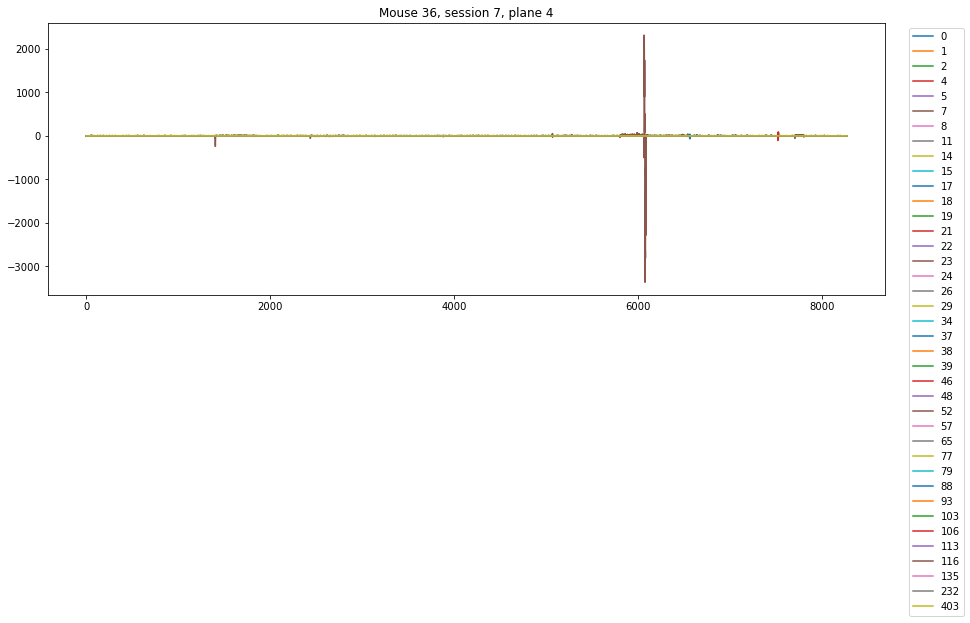

In [110]:
large_dff_inds = np.where(max_dff_vals>10)[0]
fig, ax = plt.subplots(figsize=(15,5))
for i in range(len(large_dff_inds)):
    ax.plot(dff_cells[large_dff_inds[i],:], label=f'{iscell_inds[large_dff_inds[i]]}')
# legend location outside plot
ax.legend(bbox_to_anchor=(1.1, 1.0), loc='upper right')
ax.set_title(f'Mouse {mouse}, session {session}, plane {plane}')

In [112]:
# Look at the baseline calculation
F = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session:03d}/plane0/F.npy')
Fneu = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session:03d}/plane0/Fneu.npy')
ops = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session:03d}/plane0/ops.npy', allow_pickle=True).item()
assert ops['neucoeff'] == 0.7

dF = F - ops['neucoeff'] *Fneu
win = int(ops['win_baseline'] * ops['fs'])
sig_baseline = ops['sig_baseline']
Flow1 = filters.gaussian_filter(dF,    [0., sig_baseline])
Flow2 = filters.minimum_filter1d(Flow1,    win)
Flow = filters.maximum_filter1d(Flow2,    win)


Text(0.5, 1.0, 'Mouse 36, session 7, plane 4, ROI 116')

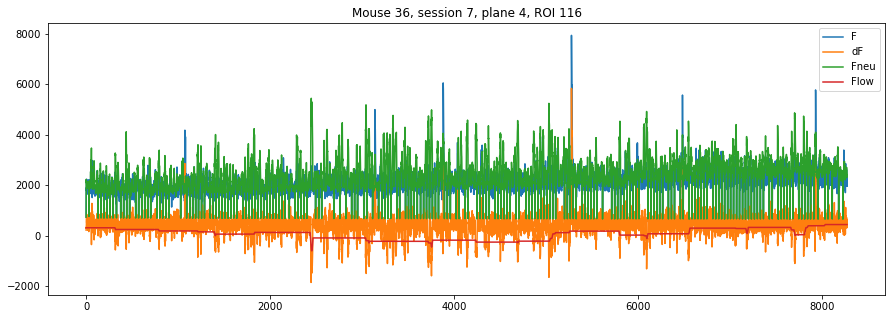

In [114]:
roi_ind = 116
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(F[roi_ind,:], label='F')

ax.plot(dF[roi_ind,:], label='dF')
ax.plot(Fneu[roi_ind,:], label='Fneu')
ax.plot(Flow[roi_ind,:], label='Flow')

# ax.plot(dff_saved[roi_ind,:], label='dff')

ax.legend()
ax.set_title(f'Mouse {mouse}, session {session}, plane {plane}, ROI {roi_ind}')

# Conclusion:
## Causes:
- Large neuropil signal
    - Usually from those near a very bright cell with horizontal dendrites. The dendrite signals are not removed, because they are not captured as ROIs.
- Baseline too close to 0
- NOT due to bad ROI

## Possible solutions
- Variable neuropil coefficient – Fneu not to exceed F, max at 0.7
    - It will fix negative values
    - But dF being close to 0 can inflate dF/F
- Just using spikes?
    - No – it depends on F-Fneu*coeff. There is spurious activity where neuropil was high.
- Rolling 10 percentile for F0
    - Can take too long
- Baseline as max(noise std, percentile) as in ABO

## Easiest solution:
- Variable neuropil coefficient with 10-min rolling 10 percentile for F0 and limit baseline no less than noise std (following ABO)
- Use this for spike inference as well.
- Only on the ‘iscell’ ROIs.
- Better after master ROI map.




# Another problem:
- During this process, I could see so many good ROIs being missed.
- Cannot do manual curation again.
- Just run cellpose on meanImg, meanImgE, and max_proj
    - ALWAYS re-calculate the enhanced mean image and then save it back to the ops file.
